**Data extraction from a PDF table with unstructured data**

__Naturally, you’ve seen quite a lot of PDFs in the form of invoices, purchase orders, shipping notes, price-lists etc. Despite serving as a digital replacement of paper PDF documents present a challenge for automated manipulation with data they store.__

In [1]:
import tempfile
from io import StringIO
import tabula
import camelot
import pandas as pd
import numpy as np
import pdftotext
from PIL import Image, ImageFont, ImageDraw
from pdf2image import convert_from_path
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser
import dataframe_image as dfi
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)

**Reading unstructure pdf file and convert to image**

In [2]:
PDF = '/home/jayanthikishore/Desktop/Analysis/Work/ML_EIT/Data/Unstructured.pdf'
pdf_img = convert_from_path(PDF, dpi=300)[0]


**Read tables in a PDF into DataFrame 

In [3]:
tabula_df = (tabula.read_pdf(PDF, stream=True,pages="all"))
# display(tabula_df)

import camelot.io as camelot
camelot_df = (camelot.read_pdf(PDF,flavor="stream",suppress_stdout=True,
                               pages="all")[0].df)

display(camelot_df)

,0
0,LINE PACK SIZE GTIN/VND CODE ITEM DESCRIPTION ITM#/VN IT WH TH QTY PRICE(CAD) FREIGHT ALLOW
1,9 9 0R 73470443870183 LHZIOF DNGEQYSHB SGBWI TSPZ 5676159 79/26 10 69.7102 9.6273
2,000545 524700
3,3 35 474HE 61400124450528 PLDMJQL PRPSDCQE 0768061 62/54 3 554.6089 .3367
4,953202
5,9 9 5.9VM 61398568193249 RARR ZSS GKEHFT 9669044 08/61 61 60.7613 .9995
6,549245
7,1 10 7.21JX 31400993339658 RXHS RVQQLP UDHANE 1343734 95/24 59 13.4181 7.3008
8,ZOU665
9,7 9 9L 89860708403417 ROP YRQUP RA BHMOZUAVL 8441178 88/73 8 245.3026 7.8962


In [4]:
pdfminer_string = StringIO()
with open(PDF, "rb") as in_file:
    parser = PDFParser(in_file)
    doc = PDFDocument(parser)
    rsrcmgr = PDFResourceManager()
    device = TextConverter(rsrcmgr,
                           pdfminer_string,
                           laparams=LAParams())
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    for page in PDFPage.create_pages(doc):
        interpreter.process_page(page)
pdfminer_lines = pdfminer_string.getvalue().splitlines()
pdfminer_lines = [ln for ln in pdfminer_lines if ln]


with open(PDF, 'rb') as file:
    pdftotext_string = pdftotext.PDF(file)
pdftotext_lines = ("\n\n".join(pdftotext_string).splitlines())
pdftotext_lines = [ln for ln in pdftotext_lines if ln]

In [5]:
%run -i 'dframe_2_image.py'
%run -i 'create_lnes_imge.py'

def adjust_string(string, out_width):
    fill_width = out_width - len(string)
    string += ' ' * fill_width
    return string

In [6]:
pdf_lines = pd.Series(pdfminer_lines)
max_width = pdf_lines.str.len().max()
pdf_lines_adjusted = pdf_lines.apply(adjust_string, args=(max_width, ))
pdf_lines_mtx = np.stack(pdf_lines_adjusted.map(list).to_numpy())


whitespace_сols = np.where(np.all(pdf_lines_mtx == ' ', axis=0))[0]
rightmost_whitespace_cols = np.where(np.diff(whitespace_сols) != 1)[0]
column_dividers = np.append(whitespace_сols[rightmost_whitespace_cols],
                            whitespace_сols[-1])



df_mtx = pd.DataFrame(pdf_lines_mtx)
df_mtx_w_dividers = df_mtx.copy()

df_mtx_w_dividers.loc[:, column_dividers] = (df_mtx_w_dividers[column_dividers]
                                             .replace({' ': '\u2022'}))

In [7]:
splitted_lines = []
for row in pdf_lines_adjusted:
    current_row = []
    for e in range(len(column_dividers) - 1):
        if e == 0:
            current_row.append(row[: column_dividers[e]].strip())
        (current_row
         .append(row[column_dividers[e]: column_dividers[e + 1]]
                 .strip()))
    current_row.append(row[column_dividers[-1]:].strip())
    splitted_lines.append(current_row)

In [8]:
pdf_df = pd.DataFrame(splitted_lines)
empty_cols = (pdf_df == '').all()
pdf_df = pdf_df[pdf_df.columns[~empty_cols]]

# plt.figure(figsize=(15, 10))
# plt.axis('off')
# plt.imshow(dframe_2_image(pdf_df))

In [9]:
header_row = pdf_df.iloc[0, :].copy()
table_rows = pdf_df.iloc[1:, :].copy()

odd_rows = table_rows.iloc[::2].copy()
odd_rows.reset_index(drop=True, inplace=True)

evn_rows = table_rows[1::2].copy()
evn_rows.reset_index(drop=True, inplace=True)

evn_rows.replace({'': np.nan}, inplace=True)
evn_rows.dropna(axis=1, how='all', inplace=True)

all_rows = pd.concat([odd_rows, evn_rows], axis=1, sort=True)
all_rows.sort_index(axis=1, inplace=True)
all_rows.columns = all_rows.columns.astype(str)
all_rows.reset_index(drop=True, inplace=True)
all_rows.replace({np.nan: ''}, inplace=True)

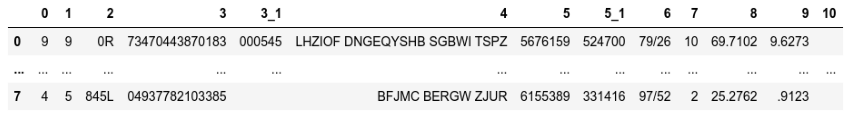

In [10]:
%run -i 'fix_arrange_columns.py'

all_rows.columns = fix_arrange_columns(all_rows.columns.astype(int).tolist())

plt.figure(figsize=(15, 5))
plt.axis('off')
plt.imshow(dframe_2_image(all_rows, max_rows=3))

In [11]:
header_splitted = header_row.str.split('/')

header_indicies = []
for i, element in enumerate(header_splitted):
    if len(element) == 1:
        header_indicies.append(str(i))
    else:
        for j, w in enumerate(element):
            if j == 0:
                header_indicies.append(str(i))
            else:
                header_indicies.append('{}_{}'.format(i, j))

header_elements = [item for sublist in header_splitted
                   for item in sublist]

column_names = pd.Series(data=header_elements,
                         index=header_indicies)

print(column_names)

0                  LINE
1                  PACK
2                  SIZE
3                  GTIN
3_1            VND CODE
4      ITEM DESCRIPTION
5                  ITM#
5_1               VN IT
6                 WH TH
7                   QTY
8            PRICE(CAD)
9               FREIGHT
10                ALLOW
dtype: object


In [12]:
all_rows.columns = column_names[all_rows.columns]

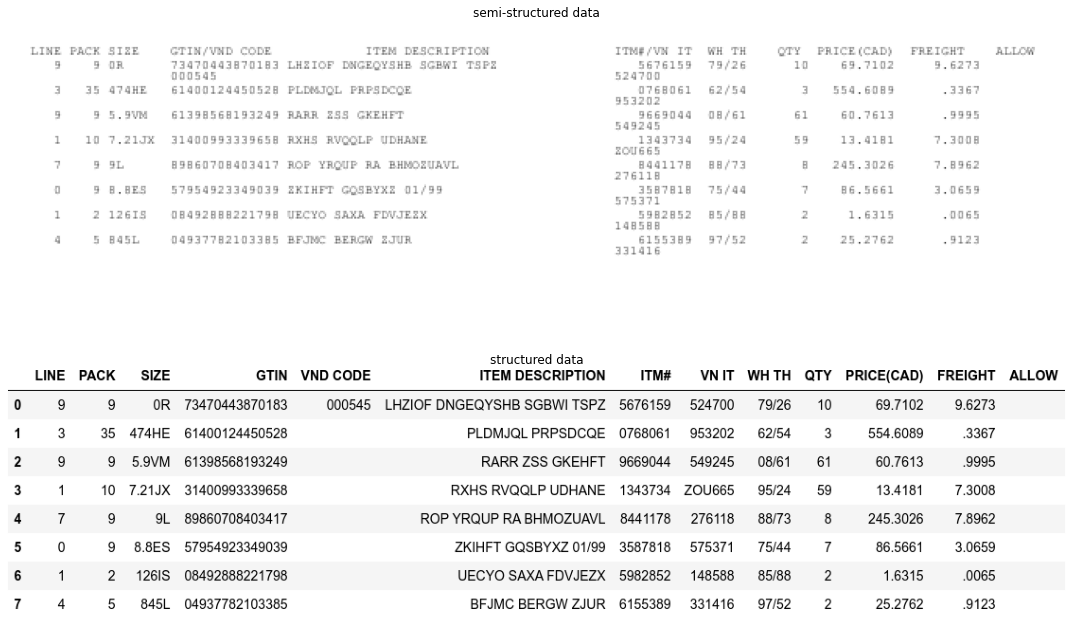

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
titles = ['semi-structured data', 'structured data']
for i, img in enumerate([create_lnes_imge(pdfminer_lines),
                         dframe_2_image(all_rows)]):
    ax[i].axis("off")
    ax[i].set_adjustable("box")
    ax[i].title.set_text(titles[i])
    ax[i].imshow(img)
fig.tight_layout()
plt.savefig('/home/jayanthikishore/Downloads/test.png')

In [14]:
all_rows.columns

Index(['LINE', 'PACK', 'SIZE', 'GTIN', 'VND CODE', 'ITEM DESCRIPTION', 'ITM#',
       'VN IT', 'WH TH', 'QTY', 'PRICE(CAD)', 'FREIGHT', 'ALLOW'],
      dtype='object')